In [21]:
import pandas as pd
import numpy as np
from utils import misc
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



# Forecasting SPX Returns with Machine Learning

From the previous notebook, we gathered macro-economic indicators that might indicate a market-regime-shift. In this notebook, we collated these indicators and build a ML model to predict subsequent SPX returns.

In [22]:
# Gather macro-economic data

# equity allocation ratio
df1 = pd.read_csv('datasets/indicators/equity_allocation.csv')
# unemployment rate
df2 = pd.read_csv('datasets/macro_data/unemployment_rate.csv')
# Real Retail Services and Food Services
df3 = pd.read_csv('datasets/macro_data/RRSFS.csv')
# Federal interest rate
df4 = pd.read_csv('datasets/macro_data/DFF.csv')
# Inflation rate (CPI)
df5 = pd.read_csv('datasets/macro_data/inflation.csv')
# SPX
df6 = pd.read_csv('datasets/macro_data/SPX.csv')

df1 = misc.clean_df(df1)
df2 = misc.clean_df(df2)
df3 = misc.clean_df(df3)
df4 = misc.clean_df(df4)
df5 = misc.clean_df(df5)
df6 = misc.clean_df(df6)



### Data preprocessing

Pre-process data as described in previous notebook.

In [23]:
df1 = df1[['DATE', 'equity_allocation']]

df2['ma'] = df2['UNRATE'].rolling(12).mean()
diff = df2['UNRATE'] - df2['ma']
df2['ue_grad'] = [1 if f > 0 else 0 for f in diff ]
mask = df2['ue_grad'] > df2['ue_grad'].shift(1)
df2['ue_indicator'] = [1 if f else 0 for f in mask]
df2.dropna(inplace=True)

mask = df3['RRSFS'] < 0 
mask2 = df3['RRSFS'].shift(1) > 0
df3['rrs_indicator'] = [1 if mask[i] and mask2[i] else 0 for i in range(len(mask))]
df3.dropna(inplace=True)

arr = [df1, df2, df3, df4, df5]

df1.set_index('DATE', inplace=True)
df1 = df1.resample('D').ffill()
df2.set_index('DATE', inplace=True)
df2 = df2.resample('D').ffill()
df3.set_index('DATE', inplace=True)
df3 = df3.resample('D').ffill()
df4.set_index('DATE', inplace=True)
df4 = df4.resample('D').ffill()
df5.set_index('DATE', inplace=True)
df5 = df5.resample('D').ffill()
    

for df in [df1, df2, df3, df4, df5]:
    display(df)
    

,equity_allocation
DATE,
1945-10-01,0.304707
1945-10-02,0.304707
1945-10-03,0.304707
1945-10-04,0.304707
1945-10-05,0.304707
...,...
2022-12-28,0.450128
2022-12-29,0.450128
2022-12-30,0.450128


,UNRATE,ma,ue_grad,ue_indicator
DATE,,,,
1948-12-01,4.0,3.750000,1,1
1948-12-02,4.0,3.750000,1,1
1948-12-03,4.0,3.750000,1,1
1948-12-04,4.0,3.750000,1,1
1948-12-05,4.0,3.750000,1,1
...,...,...,...,...
2023-04-27,3.4,3.550000,0,0
2023-04-28,3.4,3.550000,0,0
2023-04-29,3.4,3.550000,0,0


,RRSFS,rrs_indicator
DATE,,
1948-01-01,3.02432,0
1948-01-02,3.02432,0
1948-01-03,3.02432,0
1948-01-04,3.02432,0
1948-01-05,3.02432,0
...,...,...
2023-04-27,-3.55096,0
2023-04-28,-3.55096,0
2023-04-29,-3.55096,0


,DFF
DATE,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88
...,...
2023-06-17,5.08
2023-06-18,5.08
2023-06-19,5.08


,CORESTICKM159SFRBATL
DATE,
1967-12-01,3.383497
1967-12-02,3.383497
1967-12-03,3.383497
1967-12-04,3.383497
1967-12-05,3.383497
...,...
2023-04-27,6.322749
2023-04-28,6.322749
2023-04-29,6.322749


Merge dataframes together

In [24]:
df = pd.merge(df1, df2, left_index=True, right_index=True)
df = pd.merge(df, df3, left_index=True, right_index=True)
df = pd.merge(df, df4, left_index=True, right_index=True)
df = pd.merge(df, df5, left_index=True, right_index=True)
df.drop_duplicates(inplace=True)
df = df.resample('D').ffill()
display(df)
# df.to_csv('datasets/indicators/collated_macro.csv')

,equity_allocation,UNRATE,ma,ue_grad,ue_indicator,RRSFS,rrs_indicator,DFF,CORESTICKM159SFRBATL
DATE,,,,,,,,,
1967-12-01,0.426312,3.8,3.841667,0,0,0.23718,0,4.50,3.383497
1967-12-02,0.426312,3.8,3.841667,0,0,0.23718,0,4.50,3.383497
1967-12-03,0.426312,3.8,3.841667,0,0,0.23718,0,4.50,3.383497
1967-12-04,0.426312,3.8,3.841667,0,0,0.23718,0,4.25,3.383497
1967-12-05,0.426312,3.8,3.841667,0,0,0.23718,0,4.25,3.383497
...,...,...,...,...,...,...,...,...,...
2022-12-28,0.450128,3.5,3.641667,0,0,-0.43486,0,4.33,6.617223
2022-12-29,0.450128,3.5,3.641667,0,0,-0.43486,0,4.33,6.617223
2022-12-30,0.450128,3.5,3.641667,0,0,-0.43486,0,4.33,6.617223


### Prepare SPX data for forecasting

We want to predict the subsequent 1-yr SPX returns. SPX data is obtained as close for each trading day. We calculate the 1-yr return by using a rolling window of 252 trading days in a year and shift it forward to get the subsequent 1-yr returns.

In [26]:
df6.set_index('DATE', inplace=True)

df = pd.merge(df, df6, left_index=True, right_index=True)
n = 252
df['pret'] = df['SPX'].rolling(n).apply(misc.get_total_return, raw=True)
df['ret'] = df['pret'].shift(-n)
df.dropna(inplace=True)

display(df)


,equity_allocation,UNRATE,ma,ue_grad,ue_indicator,RRSFS,rrs_indicator,DFF,CORESTICKM159SFRBATL,SPX,pret,ret
DATE,,,,,,,,,,,,
1971-03-22,0.399095,6.0,5.425000,1,0,5.12143,0,3.38,5.533559,100.620003,0.120865,0.076187
1971-03-23,0.399095,6.0,5.425000,1,0,5.12143,0,3.38,5.533559,100.279999,0.115214,0.080004
1971-03-24,0.399095,6.0,5.425000,1,0,5.12143,0,3.38,5.533559,99.620003,0.111458,0.071077
1971-03-25,0.399095,6.0,5.425000,1,0,5.12143,0,3.38,5.533559,99.610001,0.111347,0.068934
1971-03-26,0.399095,6.0,5.425000,1,0,5.12143,0,3.38,5.533559,99.949997,0.109692,0.077177
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,0.516944,3.9,5.366667,0,0,7.76822,0,0.08,3.484143,4725.790039,0.276185,-0.197523
2021-12-27,0.516944,3.9,5.366667,0,0,7.76822,0,0.08,3.484143,4791.189941,0.282658,-0.199964
2021-12-28,0.516944,3.9,5.366667,0,0,7.76822,0,0.08,3.484143,4786.350098,0.284223,-0.210688


In [31]:
# Drop duplicates since macro-economic data is updated monthly/quarterly and the many trading days within each update period will affect the prediction
df.drop_duplicates(inplace=True, subset=['equity_allocation', 'UNRATE', 'ma', 'ue_grad', 'ue_indicator', 'RRSFS', 'rrs_indicator', 'DFF', 'CORESTICKM159SFRBATL'])
df

,equity_allocation,UNRATE,ma,ue_grad,ue_indicator,RRSFS,rrs_indicator,DFF,CORESTICKM159SFRBATL,SPX,pret,ret
DATE,,,,,,,,,,,,
1971-03-22,0.399095,6.0,5.425000,1,0,5.12143,0,3.38,5.533559,100.620003,0.120865,0.076187
1971-03-30,0.399095,6.0,5.425000,1,0,5.12143,0,4.50,5.533559,100.260002,0.121602,0.069684
1971-04-01,0.393305,5.9,5.533333,1,0,6.10769,0,4.00,5.338291,100.389999,0.134094,0.058970
1971-04-02,0.393305,5.9,5.533333,1,0,6.10769,0,3.88,5.338291,100.559998,0.136400,0.063598
1971-04-06,0.393305,5.9,5.533333,1,0,6.10769,0,4.25,5.338291,101.510002,0.150385,0.060208
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,0.516944,4.5,5.808333,0,0,8.21955,0,0.08,3.035619,4357.040039,0.301223,-0.144643
2021-10-29,0.516944,4.5,5.808333,0,0,8.21955,0,0.07,3.035619,4605.379883,0.408390,-0.160759
2021-11-01,0.516944,4.2,5.600000,0,0,9.79033,0,0.08,3.214320,4613.669922,0.393757,-0.167266


### Building and Tuning LGBM model

We use the Light Gradient Boosting Machine (LGBM) to build a regression model and use optuna for hyperparameter tuning.

In [28]:


# Split the data into features (unemployment rate) and target (30-day SPY returns)
X = df[['ue_grad', 'ue_indicator', 'rrs_indicator', 'equity_allocation', 'CORESTICKM159SFRBATL', 'DFF', 'UNRATE']]
y = df['ret']

# Define objective function for Optuna
def objective(trial):
    
    # Define parameters to tune
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'verbosity': -1,
        'n_jobs': 1,
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }


    # Load your dataset and split it into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred)

    return rmse

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get best hyperparameters and accuracy
best_params = study.best_params
best_rmse = study.best_value

print('Best Hyperparameters:', best_params)
print('Best RMSE:', best_rmse)

[I 2023-06-28 12:10:07,666] A new study created in memory with name: no-name-a4255a67-5e81-4b9f-8831-9f2fea2b0a91
[I 2023-06-28 12:10:07,731] Trial 0 finished with value: 0.005773849647384467 and parameters: {'num_leaves': 40, 'learning_rate': 0.13306232280312394, 'feature_fraction': 0.43917522799483977, 'bagging_fraction': 0.26909971902220337, 'bagging_freq': 4, 'min_child_samples': 90}. Best is trial 0 with value: 0.005773849647384467.
[I 2023-06-28 12:10:07,823] Trial 1 finished with value: 0.0016616495778655092 and parameters: {'num_leaves': 25, 'learning_rate': 0.1783300948982641, 'feature_fraction': 0.8120773449166014, 'bagging_fraction': 0.9856995214955591, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 1 with value: 0.0016616495778655092.


[LightGBM] [Warning] feature_fraction is set=0.43917522799483977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43917522799483977
[LightGBM] [Warning] bagging_fraction is set=0.26909971902220337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26909971902220337
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8120773449166014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8120773449166014
[LightGBM] [Warning] bagging_fraction is set=0.9856995214955591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9856995214955591
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4580328824627029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4580328824627029
[LightGBM] [Warning] bag

[I 2023-06-28 12:10:07,929] Trial 2 finished with value: 0.002748722674378055 and parameters: {'num_leaves': 36, 'learning_rate': 0.12206860041982849, 'feature_fraction': 0.4580328824627029, 'bagging_fraction': 0.7852038252158129, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 1 with value: 0.0016616495778655092.
[I 2023-06-28 12:10:08,017] Trial 3 finished with value: 0.0014214611146714689 and parameters: {'num_leaves': 44, 'learning_rate': 0.40893274738908664, 'feature_fraction': 0.9304960258354709, 'bagging_fraction': 0.8031769134982445, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 3 with value: 0.0014214611146714689.
[I 2023-06-28 12:10:08,098] Trial 4 finished with value: 0.0020424137243397794 and parameters: {'num_leaves': 22, 'learning_rate': 0.13121270644500826, 'feature_fraction': 0.6698031447271946, 'bagging_fraction': 0.745053742251609, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 3 with value: 0.0014214611146714689.


[LightGBM] [Warning] feature_fraction is set=0.9304960258354709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9304960258354709
[LightGBM] [Warning] bagging_fraction is set=0.8031769134982445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031769134982445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6698031447271946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6698031447271946
[LightGBM] [Warning] bagging_fraction is set=0.745053742251609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.745053742251609
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7407432257123922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7407432257123922
[LightGBM] [Warning] bagging_f

[I 2023-06-28 12:10:08,148] Trial 5 finished with value: 0.001686296389468792 and parameters: {'num_leaves': 9, 'learning_rate': 0.4970835279996209, 'feature_fraction': 0.7407432257123922, 'bagging_fraction': 0.934868643030871, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 3 with value: 0.0014214611146714689.
[I 2023-06-28 12:10:08,203] Trial 6 finished with value: 0.004177689283957907 and parameters: {'num_leaves': 9, 'learning_rate': 0.30141421070475727, 'feature_fraction': 0.2980311758089348, 'bagging_fraction': 0.8967702767342483, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 3 with value: 0.0014214611146714689.
[I 2023-06-28 12:10:08,254] Trial 7 finished with value: 0.01065887401296066 and parameters: {'num_leaves': 16, 'learning_rate': 0.11727143060255044, 'feature_fraction': 0.18001537432833564, 'bagging_fraction': 0.9232096189613266, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 3 with value: 0.0014214611146714689.
[I 2023-06-28 12:10:08,

[LightGBM] [Warning] feature_fraction is set=0.2980311758089348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2980311758089348
[LightGBM] [Warning] bagging_fraction is set=0.8967702767342483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967702767342483
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18001537432833564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18001537432833564
[LightGBM] [Warning] bagging_fraction is set=0.9232096189613266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9232096189613266
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8372347535755258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8372347535755258
[LightGBM] [Warning] baggi

[I 2023-06-28 12:10:08,362] Trial 9 finished with value: 0.02838298943664279 and parameters: {'num_leaves': 2, 'learning_rate': 0.1489594794247744, 'feature_fraction': 0.12800538276384604, 'bagging_fraction': 0.1950204861953302, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 3 with value: 0.0014214611146714689.
[I 2023-06-28 12:10:08,487] Trial 10 finished with value: 0.007925998287482514 and parameters: {'num_leaves': 50, 'learning_rate': 0.01201221246769732, 'feature_fraction': 0.9830158213095014, 'bagging_fraction': 0.5794964038507011, 'bagging_freq': 9, 'min_child_samples': 54}. Best is trial 3 with value: 0.0014214611146714689.


[LightGBM] [Warning] feature_fraction is set=0.12800538276384604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12800538276384604
[LightGBM] [Warning] bagging_fraction is set=0.1950204861953302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1950204861953302
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9830158213095014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9830158213095014
[LightGBM] [Warning] bagging_fraction is set=0.5794964038507011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5794964038507011
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.9918186155020758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9918186155020758
[LightGBM] [Warning] baggi

[I 2023-06-28 12:10:08,586] Trial 11 finished with value: 0.001478859553312335 and parameters: {'num_leaves': 35, 'learning_rate': 0.3497178198790272, 'feature_fraction': 0.9918186155020758, 'bagging_fraction': 0.7103918404678028, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 3 with value: 0.0014214611146714689.
[I 2023-06-28 12:10:08,696] Trial 12 finished with value: 0.0014707882962879508 and parameters: {'num_leaves': 43, 'learning_rate': 0.3953802498607133, 'feature_fraction': 0.997977900354258, 'bagging_fraction': 0.6321724270739738, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 3 with value: 0.0014214611146714689.


[LightGBM] [Warning] feature_fraction is set=0.997977900354258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.997977900354258
[LightGBM] [Warning] bagging_fraction is set=0.6321724270739738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6321724270739738
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8790535535303279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8790535535303279
[LightGBM] [Warning] bagging_fraction is set=0.5205766552468196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5205766552468196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-28 12:10:08,823] Trial 13 finished with value: 0.00141761607184285 and parameters: {'num_leaves': 49, 'learning_rate': 0.43013430014130666, 'feature_fraction': 0.8790535535303279, 'bagging_fraction': 0.5205766552468196, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 13 with value: 0.00141761607184285.
[I 2023-06-28 12:10:08,959] Trial 14 finished with value: 0.0016805330116648927 and parameters: {'num_leaves': 50, 'learning_rate': 0.4471922531554667, 'feature_fraction': 0.6070883849573693, 'bagging_fraction': 0.40245442759378863, 'bagging_freq': 8, 'min_child_samples': 35}. Best is trial 13 with value: 0.00141761607184285.


[LightGBM] [Warning] feature_fraction is set=0.6070883849573693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6070883849573693
[LightGBM] [Warning] bagging_fraction is set=0.40245442759378863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40245442759378863
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8502090553359897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8502090553359897
[LightGBM] [Warning] bagging_fraction is set=0.47914677557023505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47914677557023505
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-28 12:10:09,096] Trial 15 finished with value: 0.0014256589118342702 and parameters: {'num_leaves': 44, 'learning_rate': 0.40009894514330185, 'feature_fraction': 0.8502090553359897, 'bagging_fraction': 0.47914677557023505, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 13 with value: 0.00141761607184285.
[I 2023-06-28 12:10:09,217] Trial 16 finished with value: 0.001562959039285538 and parameters: {'num_leaves': 35, 'learning_rate': 0.4968803486248048, 'feature_fraction': 0.711155365263076, 'bagging_fraction': 0.49879452767608434, 'bagging_freq': 7, 'min_child_samples': 68}. Best is trial 13 with value: 0.00141761607184285.


[LightGBM] [Warning] feature_fraction is set=0.711155365263076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.711155365263076
[LightGBM] [Warning] bagging_fraction is set=0.49879452767608434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49879452767608434
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8903463730568768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8903463730568768
[LightGBM] [Warning] bagging_fraction is set=0.6702047866727971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6702047866727971
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-28 12:10:09,355] Trial 17 finished with value: 0.0013126480660342961 and parameters: {'num_leaves': 46, 'learning_rate': 0.3111137760098924, 'feature_fraction': 0.8903463730568768, 'bagging_fraction': 0.6702047866727971, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:09,470] Trial 18 finished with value: 0.0013884802595222506 and parameters: {'num_leaves': 31, 'learning_rate': 0.2723296740317931, 'feature_fraction': 0.8901232167995013, 'bagging_fraction': 0.6432086925086938, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 17 with value: 0.0013126480660342961.


[LightGBM] [Warning] feature_fraction is set=0.8901232167995013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901232167995013
[LightGBM] [Warning] bagging_fraction is set=0.6432086925086938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6432086925086938
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7677803641033025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7677803641033025
[LightGBM] [Warning] bagging_fraction is set=0.6432179759594552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6432179759594552
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-28 12:10:09,583] Trial 19 finished with value: 0.001594487487274733 and parameters: {'num_leaves': 28, 'learning_rate': 0.25694733303319034, 'feature_fraction': 0.7677803641033025, 'bagging_fraction': 0.6432179759594552, 'bagging_freq': 10, 'min_child_samples': 44}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:09,709] Trial 20 finished with value: 0.0014872546207010335 and parameters: {'num_leaves': 31, 'learning_rate': 0.32099402352700146, 'feature_fraction': 0.9022894316949063, 'bagging_fraction': 0.6409244193274453, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 17 with value: 0.0013126480660342961.


[LightGBM] [Warning] feature_fraction is set=0.9022894316949063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9022894316949063
[LightGBM] [Warning] bagging_fraction is set=0.6409244193274453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6409244193274453
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8777871292485637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8777871292485637
[LightGBM] [Warning] bagging_fraction is set=0.49258700148819995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49258700148819995
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-28 12:10:09,856] Trial 21 finished with value: 0.0013865192716383142 and parameters: {'num_leaves': 47, 'learning_rate': 0.2760190904904933, 'feature_fraction': 0.8777871292485637, 'bagging_fraction': 0.49258700148819995, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:10,004] Trial 22 finished with value: 0.001476070454096735 and parameters: {'num_leaves': 40, 'learning_rate': 0.2540311753008918, 'feature_fraction': 0.791347859157741, 'bagging_fraction': 0.4152214480499183, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 17 with value: 0.0013126480660342961.


[LightGBM] [Warning] feature_fraction is set=0.791347859157741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.791347859157741
[LightGBM] [Warning] bagging_fraction is set=0.4152214480499183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4152214480499183
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8920765033887669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8920765033887669
[LightGBM] [Warning] bagging_fraction is set=0.5881079123625151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5881079123625151
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-28 12:10:10,096] Trial 23 finished with value: 0.0014702309768569112 and parameters: {'num_leaves': 20, 'learning_rate': 0.25609456987901685, 'feature_fraction': 0.8920765033887669, 'bagging_fraction': 0.5881079123625151, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:10,236] Trial 24 finished with value: 0.001365848181764907 and parameters: {'num_leaves': 46, 'learning_rate': 0.35278846837508937, 'feature_fraction': 0.6840113787209138, 'bagging_fraction': 0.7057009374450881, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 17 with value: 0.0013126480660342961.


[LightGBM] [Warning] feature_fraction is set=0.6840113787209138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6840113787209138
[LightGBM] [Warning] bagging_fraction is set=0.7057009374450881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7057009374450881
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6766476567983765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6766476567983765
[LightGBM] [Warning] bagging_fraction is set=0.85245989321275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85245989321275
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-06-28 12:10:10,384] Trial 25 finished with value: 0.0014007037317273839 and parameters: {'num_leaves': 46, 'learning_rate': 0.34938721925937966, 'feature_fraction': 0.6766476567983765, 'bagging_fraction': 0.85245989321275, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:10,522] Trial 26 finished with value: 0.0013455422520659056 and parameters: {'num_leaves': 39, 'learning_rate': 0.3606394867556527, 'feature_fraction': 0.779379591398603, 'bagging_fraction': 0.706727220646661, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 17 with value: 0.0013126480660342961.


[LightGBM] [Warning] feature_fraction is set=0.779379591398603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.779379591398603
[LightGBM] [Warning] bagging_fraction is set=0.706727220646661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.706727220646661
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6250841703257132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6250841703257132
[LightGBM] [Warning] bagging_fraction is set=0.7114916244880755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7114916244880755
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-28 12:10:10,651] Trial 27 finished with value: 0.001470375660781246 and parameters: {'num_leaves': 39, 'learning_rate': 0.3558610229922339, 'feature_fraction': 0.6250841703257132, 'bagging_fraction': 0.7114916244880755, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:10,775] Trial 28 finished with value: 0.0014238797010940193 and parameters: {'num_leaves': 41, 'learning_rate': 0.3147624825971909, 'feature_fraction': 0.7323816392057261, 'bagging_fraction': 0.8349200184096977, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 17 with value: 0.0013126480660342961.


[LightGBM] [Warning] feature_fraction is set=0.7323816392057261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7323816392057261
[LightGBM] [Warning] bagging_fraction is set=0.8349200184096977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8349200184096977
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5143712302679304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5143712302679304
[LightGBM] [Warning] bagging_fraction is set=0.7366086981459758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7366086981459758
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-06-28 12:10:10,905] Trial 29 finished with value: 0.0015418284458663316 and parameters: {'num_leaves': 37, 'learning_rate': 0.36836186555731365, 'feature_fraction': 0.5143712302679304, 'bagging_fraction': 0.7366086981459758, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:11,059] Trial 30 finished with value: 0.0014060539634320876 and parameters: {'num_leaves': 47, 'learning_rate': 0.3740334374550239, 'feature_fraction': 0.7723477468901587, 'bagging_fraction': 0.8649335166367279, 'bagging_freq': 8, 'min_child_samples': 61}. Best is trial 17 with value: 0.0013126480660342961.


[LightGBM] [Warning] feature_fraction is set=0.7723477468901587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723477468901587
[LightGBM] [Warning] bagging_fraction is set=0.8649335166367279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8649335166367279
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8241424027918397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8241424027918397
[LightGBM] [Warning] bagging_fraction is set=0.6860871460002952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6860871460002952
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-28 12:10:11,201] Trial 31 finished with value: 0.001366857139144823 and parameters: {'num_leaves': 47, 'learning_rate': 0.2920349377566067, 'feature_fraction': 0.8241424027918397, 'bagging_fraction': 0.6860871460002952, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:11,336] Trial 32 finished with value: 0.0013145872876055317 and parameters: {'num_leaves': 42, 'learning_rate': 0.3320470374836812, 'feature_fraction': 0.8161506243912222, 'bagging_fraction': 0.6886648691993261, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 17 with value: 0.0013126480660342961.


[LightGBM] [Warning] feature_fraction is set=0.8161506243912222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8161506243912222
[LightGBM] [Warning] bagging_fraction is set=0.6886648691993261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6886648691993261
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7882315991482634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7882315991482634
[LightGBM] [Warning] bagging_fraction is set=0.79874349240643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.79874349240643
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-28 12:10:11,476] Trial 33 finished with value: 0.0013747120123621193 and parameters: {'num_leaves': 41, 'learning_rate': 0.32035036553941, 'feature_fraction': 0.7882315991482634, 'bagging_fraction': 0.79874349240643, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:11,597] Trial 34 finished with value: 0.0013819553544333252 and parameters: {'num_leaves': 32, 'learning_rate': 0.3366991803699092, 'feature_fraction': 0.819801783571395, 'bagging_fraction': 0.7719450515158288, 'bagging_freq': 8, 'min_child_samples': 36}. Best is trial 17 with value: 0.0013126480660342961.


[LightGBM] [Warning] feature_fraction is set=0.819801783571395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.819801783571395
[LightGBM] [Warning] bagging_fraction is set=0.7719450515158288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7719450515158288
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6934962449007468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6934962449007468
[LightGBM] [Warning] bagging_fraction is set=0.7705637727626917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7705637727626917
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-28 12:10:11,734] Trial 35 finished with value: 0.001377061795588585 and parameters: {'num_leaves': 43, 'learning_rate': 0.3799971797691528, 'feature_fraction': 0.6934962449007468, 'bagging_fraction': 0.7705637727626917, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:11,860] Trial 36 finished with value: 0.0013820849105644383 and parameters: {'num_leaves': 39, 'learning_rate': 0.3266521325885038, 'feature_fraction': 0.9364121157708791, 'bagging_fraction': 0.6999056481256268, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 17 with value: 0.0013126480660342961.


[LightGBM] [Warning] feature_fraction is set=0.9364121157708791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9364121157708791
[LightGBM] [Warning] bagging_fraction is set=0.6999056481256268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6999056481256268
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6330703714819966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6330703714819966
[LightGBM] [Warning] bagging_fraction is set=0.8078363514306617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8078363514306617
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-06-28 12:10:11,983] Trial 37 finished with value: 0.0013244808169579297 and parameters: {'num_leaves': 45, 'learning_rate': 0.2300095700222708, 'feature_fraction': 0.6330703714819966, 'bagging_fraction': 0.8078363514306617, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:12,101] Trial 38 finished with value: 0.0014027116995718846 and parameters: {'num_leaves': 36, 'learning_rate': 0.22736971987978463, 'feature_fraction': 0.6310498581763591, 'bagging_fraction': 0.8089895144453862, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 17 with value: 0.0013126480660342961.


[LightGBM] [Warning] feature_fraction is set=0.6310498581763591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6310498581763591
[LightGBM] [Warning] bagging_fraction is set=0.8089895144453862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8089895144453862
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7278344075405986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7278344075405986
[LightGBM] [Warning] bagging_fraction is set=0.991655827629714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.991655827629714
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-28 12:10:12,232] Trial 39 finished with value: 0.0014041937561208933 and parameters: {'num_leaves': 44, 'learning_rate': 0.2189750453806402, 'feature_fraction': 0.7278344075405986, 'bagging_fraction': 0.991655827629714, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 17 with value: 0.0013126480660342961.
[I 2023-06-28 12:10:12,348] Trial 40 finished with value: 0.0013078628576563309 and parameters: {'num_leaves': 38, 'learning_rate': 0.29872724174557247, 'feature_fraction': 0.5543273445303857, 'bagging_fraction': 0.8852043030214592, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 40 with value: 0.0013078628576563309.


[LightGBM] [Warning] feature_fraction is set=0.5543273445303857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5543273445303857
[LightGBM] [Warning] bagging_fraction is set=0.8852043030214592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8852043030214592
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5774580888255477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5774580888255477
[LightGBM] [Warning] bagging_fraction is set=0.9128388113797317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9128388113797317
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-28 12:10:12,457] Trial 41 finished with value: 0.0014030296190454738 and parameters: {'num_leaves': 33, 'learning_rate': 0.2967517781465662, 'feature_fraction': 0.5774580888255477, 'bagging_fraction': 0.9128388113797317, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 40 with value: 0.0013078628576563309.
[I 2023-06-28 12:10:12,579] Trial 42 finished with value: 0.0013789097080795704 and parameters: {'num_leaves': 38, 'learning_rate': 0.308975557758866, 'feature_fraction': 0.5545975870381908, 'bagging_fraction': 0.8861253561666738, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 40 with value: 0.0013078628576563309.


[LightGBM] [Warning] feature_fraction is set=0.5545975870381908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5545975870381908
[LightGBM] [Warning] bagging_fraction is set=0.8861253561666738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8861253561666738
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5085855108033062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085855108033062
[LightGBM] [Warning] bagging_fraction is set=0.828471257008182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.828471257008182
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-28 12:10:12,713] Trial 43 finished with value: 0.0013652524324186182 and parameters: {'num_leaves': 43, 'learning_rate': 0.33838814737898315, 'feature_fraction': 0.5085855108033062, 'bagging_fraction': 0.828471257008182, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 40 with value: 0.0013078628576563309.
[I 2023-06-28 12:10:12,839] Trial 44 finished with value: 0.0014049105256539482 and parameters: {'num_leaves': 41, 'learning_rate': 0.2990295882439386, 'feature_fraction': 0.44813516856125246, 'bagging_fraction': 0.7652363088694021, 'bagging_freq': 9, 'min_child_samples': 9}. Best is trial 40 with value: 0.0013078628576563309.


[LightGBM] [Warning] feature_fraction is set=0.44813516856125246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44813516856125246
[LightGBM] [Warning] bagging_fraction is set=0.7652363088694021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7652363088694021
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6504450975201507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6504450975201507
[LightGBM] [Warning] bagging_fraction is set=0.9350823974914988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9350823974914988
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-06-28 12:10:12,965] Trial 45 finished with value: 0.0019782050943407607 and parameters: {'num_leaves': 23, 'learning_rate': 0.21948323113737767, 'feature_fraction': 0.6504450975201507, 'bagging_fraction': 0.9350823974914988, 'bagging_freq': 8, 'min_child_samples': 100}. Best is trial 40 with value: 0.0013078628576563309.
[I 2023-06-28 12:10:13,101] Trial 46 finished with value: 0.0013749927829151479 and parameters: {'num_leaves': 49, 'learning_rate': 0.2771923776723696, 'feature_fraction': 0.7560859320344403, 'bagging_fraction': 0.7502156822738266, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 40 with value: 0.0013078628576563309.


[LightGBM] [Warning] feature_fraction is set=0.7560859320344403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7560859320344403
[LightGBM] [Warning] bagging_fraction is set=0.7502156822738266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7502156822738266
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.945382863304395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945382863304395
[LightGBM] [Warning] bagging_fraction is set=0.8740023118506011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8740023118506011
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-28 12:10:13,226] Trial 47 finished with value: 0.0013183395818970884 and parameters: {'num_leaves': 45, 'learning_rate': 0.19882228105962332, 'feature_fraction': 0.945382863304395, 'bagging_fraction': 0.8740023118506011, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 40 with value: 0.0013078628576563309.
[I 2023-06-28 12:10:13,354] Trial 48 finished with value: 0.0013287742601887286 and parameters: {'num_leaves': 44, 'learning_rate': 0.18450234696604864, 'feature_fraction': 0.9445220834891056, 'bagging_fraction': 0.8739544065169398, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 40 with value: 0.0013078628576563309.


[LightGBM] [Warning] feature_fraction is set=0.9445220834891056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9445220834891056
[LightGBM] [Warning] bagging_fraction is set=0.8739544065169398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8739544065169398
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9608355746714378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9608355746714378
[LightGBM] [Warning] bagging_fraction is set=0.9660001810641603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9660001810641603
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-28 12:10:13,499] Trial 49 finished with value: 0.0013708651294353047 and parameters: {'num_leaves': 48, 'learning_rate': 0.19487330338903341, 'feature_fraction': 0.9608355746714378, 'bagging_fraction': 0.9660001810641603, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 40 with value: 0.0013078628576563309.
[I 2023-06-28 12:10:13,586] Trial 50 finished with value: 0.002001222080357327 and parameters: {'num_leaves': 14, 'learning_rate': 0.15984958892182188, 'feature_fraction': 0.8391387326287132, 'bagging_fraction': 0.8153962953375993, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 40 with value: 0.0013078628576563309.
[I 2023-06-28 12:10:13,711] Trial 51 finished with value: 0.0013038301685496295 and parameters: {'num_leaves': 43, 'learning_rate': 0.18134224884652403, 'feature_fraction': 0.9494381025506067, 'bagging_fraction': 0.8867948820561904, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 51 with value: 0.0013038301685496295.


[LightGBM] [Warning] feature_fraction is set=0.8391387326287132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8391387326287132
[LightGBM] [Warning] bagging_fraction is set=0.8153962953375993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8153962953375993
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9494381025506067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9494381025506067
[LightGBM] [Warning] bagging_fraction is set=0.8867948820561904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8867948820561904
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-28 12:10:13,834] Trial 52 finished with value: 0.001292715445402759 and parameters: {'num_leaves': 42, 'learning_rate': 0.24016007975315884, 'feature_fraction': 0.9330472966581828, 'bagging_fraction': 0.9070260958310923, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 52 with value: 0.001292715445402759.


[LightGBM] [Warning] feature_fraction is set=0.9330472966581828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9330472966581828
[LightGBM] [Warning] bagging_fraction is set=0.9070260958310923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9070260958310923
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9237201433237812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237201433237812
[LightGBM] [Warning] bagging_fraction is set=0.9384013853950021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384013853950021
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-28 12:10:13,964] Trial 53 finished with value: 0.001348484693052635 and parameters: {'num_leaves': 42, 'learning_rate': 0.20484216933658847, 'feature_fraction': 0.9237201433237812, 'bagging_fraction': 0.9384013853950021, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 52 with value: 0.001292715445402759.
[I 2023-06-28 12:10:14,083] Trial 54 finished with value: 0.0013016518108275078 and parameters: {'num_leaves': 35, 'learning_rate': 0.1779502176825464, 'feature_fraction': 0.9696434906928225, 'bagging_fraction': 0.902266637780048, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 52 with value: 0.001292715445402759.


[LightGBM] [Warning] feature_fraction is set=0.9696434906928225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9696434906928225
[LightGBM] [Warning] bagging_fraction is set=0.902266637780048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.902266637780048
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9952933216118768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9952933216118768
[LightGBM] [Warning] bagging_fraction is set=0.9073726455229971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9073726455229971
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-28 12:10:14,206] Trial 55 finished with value: 0.0014201660898170445 and parameters: {'num_leaves': 34, 'learning_rate': 0.15585430184298665, 'feature_fraction': 0.9952933216118768, 'bagging_fraction': 0.9073726455229971, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 52 with value: 0.001292715445402759.
[I 2023-06-28 12:10:14,291] Trial 56 finished with value: 0.0013545927567170804 and parameters: {'num_leaves': 29, 'learning_rate': 0.2550444018325277, 'feature_fraction': 0.8665097891945888, 'bagging_fraction': 0.9993560408464643, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial 52 with value: 0.001292715445402759.


[LightGBM] [Warning] feature_fraction is set=0.8665097891945888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8665097891945888
[LightGBM] [Warning] bagging_fraction is set=0.9993560408464643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993560408464643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9111247463607047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9111247463607047
[LightGBM] [Warning] bagging_fraction is set=0.9629749810805023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9629749810805023
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-28 12:10:14,438] Trial 57 finished with value: 0.0019247095485846874 and parameters: {'num_leaves': 37, 'learning_rate': 0.11614304463591892, 'feature_fraction': 0.9111247463607047, 'bagging_fraction': 0.9629749810805023, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 52 with value: 0.001292715445402759.
[I 2023-06-28 12:10:14,559] Trial 58 finished with value: 0.001361846680951193 and parameters: {'num_leaves': 35, 'learning_rate': 0.2392142433063566, 'feature_fraction': 0.8484275327361889, 'bagging_fraction': 0.8994414554227832, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 52 with value: 0.001292715445402759.


[LightGBM] [Warning] feature_fraction is set=0.8484275327361889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8484275327361889
[LightGBM] [Warning] bagging_fraction is set=0.8994414554227832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8994414554227832
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9746751780121768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9746751780121768
[LightGBM] [Warning] bagging_fraction is set=0.8607445030033948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8607445030033948
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-28 12:10:14,669] Trial 59 finished with value: 0.0013978863401665936 and parameters: {'num_leaves': 25, 'learning_rate': 0.282259462821549, 'feature_fraction': 0.9746751780121768, 'bagging_fraction': 0.8607445030033948, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 52 with value: 0.001292715445402759.
[I 2023-06-28 12:10:14,787] Trial 60 finished with value: 0.0014581339363498728 and parameters: {'num_leaves': 30, 'learning_rate': 0.16765939064395166, 'feature_fraction': 0.9035482184870874, 'bagging_fraction': 0.8495183697447908, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 52 with value: 0.001292715445402759.


[LightGBM] [Warning] feature_fraction is set=0.9035482184870874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9035482184870874
[LightGBM] [Warning] bagging_fraction is set=0.8495183697447908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8495183697447908
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9470959877859675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9470959877859675
[LightGBM] [Warning] bagging_fraction is set=0.9338374264706669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9338374264706669
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-28 12:10:14,911] Trial 61 finished with value: 0.0012694457277101583 and parameters: {'num_leaves': 42, 'learning_rate': 0.18325439805322782, 'feature_fraction': 0.9470959877859675, 'bagging_fraction': 0.9338374264706669, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:15,036] Trial 62 finished with value: 0.0012755456407795031 and parameters: {'num_leaves': 42, 'learning_rate': 0.1842943316120918, 'feature_fraction': 0.9568956162263256, 'bagging_fraction': 0.9290392691259296, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.9568956162263256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9568956162263256
[LightGBM] [Warning] bagging_fraction is set=0.9290392691259296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9290392691259296
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9601867491789873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9601867491789873
[LightGBM] [Warning] bagging_fraction is set=0.9442278665145187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9442278665145187
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-28 12:10:15,166] Trial 63 finished with value: 0.001369654983487894 and parameters: {'num_leaves': 40, 'learning_rate': 0.13318478642375065, 'feature_fraction': 0.9601867491789873, 'bagging_fraction': 0.9442278665145187, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:15,285] Trial 64 finished with value: 0.001311368560181089 and parameters: {'num_leaves': 37, 'learning_rate': 0.1784271291111541, 'feature_fraction': 0.9269793958373317, 'bagging_fraction': 0.8968355875117673, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.9269793958373317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9269793958373317
[LightGBM] [Warning] bagging_fraction is set=0.8968355875117673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8968355875117673
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9974541265938983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9974541265938983
[LightGBM] [Warning] bagging_fraction is set=0.9143922912264062, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9143922912264062
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-28 12:10:15,403] Trial 65 finished with value: 0.00130097266880516 and parameters: {'num_leaves': 38, 'learning_rate': 0.18106320768034811, 'feature_fraction': 0.9974541265938983, 'bagging_fraction': 0.9143922912264062, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:15,461] Trial 66 finished with value: 0.01823803384503293 and parameters: {'num_leaves': 2, 'learning_rate': 0.14398102028483445, 'feature_fraction': 0.9858249901780409, 'bagging_fraction': 0.9678930793012572, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:15,577] Trial 67 finished with value: 0.0012765023578658722 and parameters: {'num_leaves': 38, 'learning_rate': 0.20835048378286491, 'feature_fraction': 0.9617470075110429, 'bagging_fraction': 0.9127882323623311, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.9858249901780409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9858249901780409
[LightGBM] [Warning] bagging_fraction is set=0.9678930793012572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9678930793012572
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9617470075110429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9617470075110429
[LightGBM] [Warning] bagging_fraction is set=0.9127882323623311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9127882323623311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9572641491904037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9572641491904037
[LightGBM] [Warning] bagging

[I 2023-06-28 12:10:15,703] Trial 68 finished with value: 0.0013306452314804562 and parameters: {'num_leaves': 34, 'learning_rate': 0.17302530800672475, 'feature_fraction': 0.9572641491904037, 'bagging_fraction': 0.9242661622684484, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:15,825] Trial 69 finished with value: 0.0012990747894542384 and parameters: {'num_leaves': 40, 'learning_rate': 0.2093963375805251, 'feature_fraction': 0.8712187582841817, 'bagging_fraction': 0.9458258845169999, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.8712187582841817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8712187582841817
[LightGBM] [Warning] bagging_fraction is set=0.9458258845169999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458258845169999
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8718619159515715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718619159515715
[LightGBM] [Warning] bagging_fraction is set=0.9532108950482319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9532108950482319
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-28 12:10:15,945] Trial 70 finished with value: 0.0012802457408938582 and parameters: {'num_leaves': 39, 'learning_rate': 0.21702412955983105, 'feature_fraction': 0.8718619159515715, 'bagging_fraction': 0.9532108950482319, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:16,069] Trial 71 finished with value: 0.00129416514859075 and parameters: {'num_leaves': 40, 'learning_rate': 0.2072369380093539, 'feature_fraction': 0.998332984217309, 'bagging_fraction': 0.957069069239538, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.998332984217309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.998332984217309
[LightGBM] [Warning] bagging_fraction is set=0.957069069239538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957069069239538
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8789312622778364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8789312622778364
[LightGBM] [Warning] bagging_fraction is set=0.9759615503030579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9759615503030579
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-28 12:10:16,197] Trial 72 finished with value: 0.0013434197224404334 and parameters: {'num_leaves': 40, 'learning_rate': 0.20734622920155774, 'feature_fraction': 0.8789312622778364, 'bagging_fraction': 0.9759615503030579, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:16,317] Trial 73 finished with value: 0.0013020257909912047 and parameters: {'num_leaves': 38, 'learning_rate': 0.21290082720677816, 'feature_fraction': 0.9924306639156164, 'bagging_fraction': 0.9467388876641051, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.9924306639156164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9924306639156164
[LightGBM] [Warning] bagging_fraction is set=0.9467388876641051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9467388876641051
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9172391843471159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9172391843471159
[LightGBM] [Warning] bagging_fraction is set=0.9308809721058652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9308809721058652
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-28 12:10:16,437] Trial 74 finished with value: 0.0013774794373844531 and parameters: {'num_leaves': 41, 'learning_rate': 0.23935895658559736, 'feature_fraction': 0.9172391843471159, 'bagging_fraction': 0.9308809721058652, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:16,565] Trial 75 finished with value: 0.0013579811272207063 and parameters: {'num_leaves': 42, 'learning_rate': 0.18969471222545695, 'feature_fraction': 0.8987956205683565, 'bagging_fraction': 0.9947581549914755, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.8987956205683565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8987956205683565
[LightGBM] [Warning] bagging_fraction is set=0.9947581549914755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9947581549914755
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8622726585110663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8622726585110663
[LightGBM] [Warning] bagging_fraction is set=0.9575676075113089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9575676075113089
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-28 12:10:16,695] Trial 76 finished with value: 0.0013769745828721125 and parameters: {'num_leaves': 39, 'learning_rate': 0.19994437742134447, 'feature_fraction': 0.8622726585110663, 'bagging_fraction': 0.9575676075113089, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:16,762] Trial 77 finished with value: 0.004323742488581087 and parameters: {'num_leaves': 5, 'learning_rate': 0.20910557122870466, 'feature_fraction': 0.9278756139570187, 'bagging_fraction': 0.922562308395294, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:16,888] Trial 78 finished with value: 0.0013376041527742109 and parameters: {'num_leaves': 45, 'learning_rate': 0.2230942227275099, 'feature_fraction': 0.9975175881069985, 'bagging_fraction': 0.8442930411638354, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.9278756139570187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9278756139570187
[LightGBM] [Warning] bagging_fraction is set=0.922562308395294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.922562308395294
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9975175881069985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975175881069985
[LightGBM] [Warning] bagging_fraction is set=0.8442930411638354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442930411638354
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.973395575843319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.973395575843319
[LightGBM] [Warning] bagging_fra

[I 2023-06-28 12:10:17,012] Trial 79 finished with value: 0.0014150563929185885 and parameters: {'num_leaves': 36, 'learning_rate': 0.23957044902370064, 'feature_fraction': 0.973395575843319, 'bagging_fraction': 0.9771268243802205, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:17,137] Trial 80 finished with value: 0.0013599445674214005 and parameters: {'num_leaves': 32, 'learning_rate': 0.19335386548214079, 'feature_fraction': 0.8848284178804163, 'bagging_fraction': 0.9183849627866166, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.8848284178804163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8848284178804163
[LightGBM] [Warning] bagging_fraction is set=0.9183849627866166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9183849627866166
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9665443166659667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9665443166659667
[LightGBM] [Warning] bagging_fraction is set=0.9501063283391651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9501063283391651
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-28 12:10:17,259] Trial 81 finished with value: 0.0012901918778280101 and parameters: {'num_leaves': 39, 'learning_rate': 0.17584463438273706, 'feature_fraction': 0.9665443166659667, 'bagging_fraction': 0.9501063283391651, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:17,386] Trial 82 finished with value: 0.0013608063955842192 and parameters: {'num_leaves': 39, 'learning_rate': 0.16430808267341182, 'feature_fraction': 0.9399202690886949, 'bagging_fraction': 0.9465949023081941, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.9399202690886949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9399202690886949
[LightGBM] [Warning] bagging_fraction is set=0.9465949023081941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9465949023081941
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9990173347571827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9990173347571827
[LightGBM] [Warning] bagging_fraction is set=0.995601541395649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995601541395649
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-28 12:10:17,507] Trial 83 finished with value: 0.0012760454160312374 and parameters: {'num_leaves': 42, 'learning_rate': 0.21086466722914865, 'feature_fraction': 0.9990173347571827, 'bagging_fraction': 0.995601541395649, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:17,631] Trial 84 finished with value: 0.00133938289224266 and parameters: {'num_leaves': 42, 'learning_rate': 0.2117794770161863, 'feature_fraction': 0.9121398744346084, 'bagging_fraction': 0.994410665581219, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.9121398744346084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9121398744346084
[LightGBM] [Warning] bagging_fraction is set=0.994410665581219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.994410665581219
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.974601507267498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.974601507267498
[LightGBM] [Warning] bagging_fraction is set=0.9583676639414658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9583676639414658
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-28 12:10:17,757] Trial 85 finished with value: 0.0013443071839086044 and parameters: {'num_leaves': 40, 'learning_rate': 0.2303690669905773, 'feature_fraction': 0.974601507267498, 'bagging_fraction': 0.9583676639414658, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:17,885] Trial 86 finished with value: 0.0013429703742851742 and parameters: {'num_leaves': 44, 'learning_rate': 0.19357105143687703, 'feature_fraction': 0.8571143216502279, 'bagging_fraction': 0.9777874039665048, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.8571143216502279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8571143216502279
[LightGBM] [Warning] bagging_fraction is set=0.9777874039665048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9777874039665048
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9440193752720972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9440193752720972
[LightGBM] [Warning] bagging_fraction is set=0.866973443951231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.866973443951231
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-28 12:10:18,023] Trial 87 finished with value: 0.0013113344861424455 and parameters: {'num_leaves': 46, 'learning_rate': 0.2471591370456867, 'feature_fraction': 0.9440193752720972, 'bagging_fraction': 0.866973443951231, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:18,171] Trial 88 finished with value: 0.00139637792341383 and parameters: {'num_leaves': 41, 'learning_rate': 0.2633787348566995, 'feature_fraction': 0.8919341324493839, 'bagging_fraction': 0.9408929319994549, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.8919341324493839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8919341324493839
[LightGBM] [Warning] bagging_fraction is set=0.9408929319994549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9408929319994549
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9632992743751492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9632992743751492
[LightGBM] [Warning] bagging_fraction is set=0.8341324406466486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8341324406466486
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-28 12:10:18,300] Trial 89 finished with value: 0.0013374867091929016 and parameters: {'num_leaves': 43, 'learning_rate': 0.21880601570611485, 'feature_fraction': 0.9632992743751492, 'bagging_fraction': 0.8341324406466486, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 61 with value: 0.0012694457277101583.
[I 2023-06-28 12:10:18,416] Trial 90 finished with value: 0.001282178056590892 and parameters: {'num_leaves': 37, 'learning_rate': 0.2055425244851718, 'feature_fraction': 0.8023526082073781, 'bagging_fraction': 0.9783619659631858, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 61 with value: 0.0012694457277101583.


[LightGBM] [Warning] feature_fraction is set=0.8023526082073781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8023526082073781
[LightGBM] [Warning] bagging_fraction is set=0.9783619659631858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9783619659631858
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9259577820711679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9259577820711679
[LightGBM] [Warning] bagging_fraction is set=0.9998408976618235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998408976618235
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-28 12:10:18,531] Trial 91 finished with value: 0.0012687969375656948 and parameters: {'num_leaves': 36, 'learning_rate': 0.22950275844397972, 'feature_fraction': 0.9259577820711679, 'bagging_fraction': 0.9998408976618235, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 91 with value: 0.0012687969375656948.
[I 2023-06-28 12:10:18,647] Trial 92 finished with value: 0.0012594463544386653 and parameters: {'num_leaves': 37, 'learning_rate': 0.2298327477587276, 'feature_fraction': 0.9238590423216483, 'bagging_fraction': 0.9976478457808374, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 92 with value: 0.0012594463544386653.


[LightGBM] [Warning] feature_fraction is set=0.9238590423216483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9238590423216483
[LightGBM] [Warning] bagging_fraction is set=0.9976478457808374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9976478457808374
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9306433552120168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9306433552120168
[LightGBM] [Warning] bagging_fraction is set=0.99944479196914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.99944479196914
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-06-28 12:10:18,761] Trial 93 finished with value: 0.0013092062898347322 and parameters: {'num_leaves': 36, 'learning_rate': 0.22926328285338604, 'feature_fraction': 0.9306433552120168, 'bagging_fraction': 0.99944479196914, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 92 with value: 0.0012594463544386653.
[I 2023-06-28 12:10:18,907] Trial 94 finished with value: 0.0014797238048109892 and parameters: {'num_leaves': 37, 'learning_rate': 0.2388731983978889, 'feature_fraction': 0.8368822685786973, 'bagging_fraction': 0.9839608465340939, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 92 with value: 0.0012594463544386653.


[LightGBM] [Warning] feature_fraction is set=0.8368822685786973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8368822685786973
[LightGBM] [Warning] bagging_fraction is set=0.9839608465340939, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9839608465340939
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8016319982836257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8016319982836257
[LightGBM] [Warning] bagging_fraction is set=0.9686299847448948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9686299847448948
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-28 12:10:19,022] Trial 95 finished with value: 0.0012652389321638642 and parameters: {'num_leaves': 38, 'learning_rate': 0.2658331733283241, 'feature_fraction': 0.8016319982836257, 'bagging_fraction': 0.9686299847448948, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 92 with value: 0.0012594463544386653.
[I 2023-06-28 12:10:19,134] Trial 96 finished with value: 0.0012955636877508088 and parameters: {'num_leaves': 36, 'learning_rate': 0.26335134855889786, 'feature_fraction': 0.8329021391209417, 'bagging_fraction': 0.9746309715454999, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 92 with value: 0.0012594463544386653.


[LightGBM] [Warning] feature_fraction is set=0.8329021391209417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8329021391209417
[LightGBM] [Warning] bagging_fraction is set=0.9746309715454999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9746309715454999
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9061464765751492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061464765751492
[LightGBM] [Warning] bagging_fraction is set=0.9781050339408828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781050339408828
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-28 12:10:19,251] Trial 97 finished with value: 0.0013858352509528416 and parameters: {'num_leaves': 33, 'learning_rate': 0.1882630364119208, 'feature_fraction': 0.9061464765751492, 'bagging_fraction': 0.9781050339408828, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 92 with value: 0.0012594463544386653.
[I 2023-06-28 12:10:19,367] Trial 98 finished with value: 0.001297941407261302 and parameters: {'num_leaves': 34, 'learning_rate': 0.25020158933023057, 'feature_fraction': 0.7956333572205886, 'bagging_fraction': 0.9263361364007426, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 92 with value: 0.0012594463544386653.


[LightGBM] [Warning] feature_fraction is set=0.7956333572205886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7956333572205886
[LightGBM] [Warning] bagging_fraction is set=0.9263361364007426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9263361364007426
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8009697780663808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8009697780663808
[LightGBM] [Warning] bagging_fraction is set=0.8851622359824891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8851622359824891
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-28 12:10:19,489] Trial 99 finished with value: 0.0013458685022786061 and parameters: {'num_leaves': 38, 'learning_rate': 0.16896761724546921, 'feature_fraction': 0.8009697780663808, 'bagging_fraction': 0.8851622359824891, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 92 with value: 0.0012594463544386653.


Best Hyperparameters: {'num_leaves': 37, 'learning_rate': 0.2298327477587276, 'feature_fraction': 0.9238590423216483, 'bagging_fraction': 0.9976478457808374, 'bagging_freq': 7, 'min_child_samples': 8}
Best Accuracy: 0.0012594463544386653


In [29]:
# best_params = {'num_leaves': 44, 'learning_rate': 0.45757227974475645, 'feature_fraction': 0.8784088897138107, 'bagging_fraction': 0.9448292776454562, 'bagging_freq': 5, 'min_child_samples': 67}

### Results

[LightGBM] [Warning] feature_fraction is set=0.9238590423216483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9238590423216483
[LightGBM] [Warning] bagging_fraction is set=0.9976478457808374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9976478457808374
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
rmse: 0.0012594463544386653


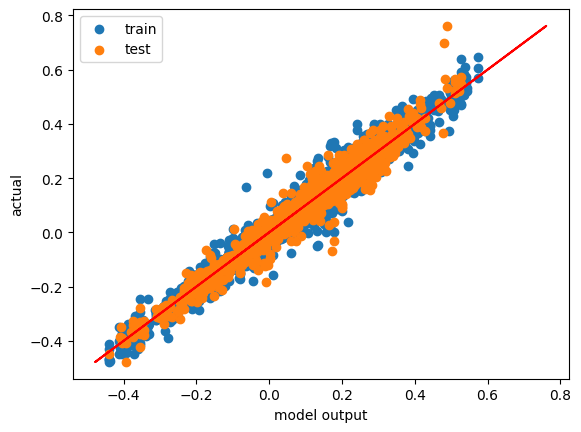

In [30]:
# Load your dataset and split it into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)

# Evaluate on validation set
y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred)
print(f'rmse: {rmse}')


plt.scatter(model.predict(X_train), y_train, label='train')
plt.scatter(y_pred, y_val, label='test')
plt.plot(y, y, color='red')
plt.xlabel('model output')
plt.ylabel('actual')
plt.legend()
plt.show()